In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## EDA

### 1. Read data

In [2]:
df_final = pd.read_csv('data/bank_transaction.csv')
df_final.head()

,CustomerID,TransactionID,TransactionDT,TransactionAmt,CardType,isRetention,Frequency
0,0,2987003,86499,50.00,platinum,1,0.524351
1,1,2987006,86522,159.00,gold,1,-0.009628
2,2,2987009,86536,117.00,platinum,1,0.266064
3,3,2987017,86668,100.00,platinum,1,0.279606
4,4,2987029,86979,36.99,gold,1,0.179209


In [3]:
df_final.shape

(57548, 7)

In [4]:
# Check missing values
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57548 entries, 0 to 57547
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CustomerID      57548 non-null  int64  
 1   TransactionID   57548 non-null  int64  
 2   TransactionDT   57548 non-null  int64  
 3   TransactionAmt  57548 non-null  float64
 4   CardType        57548 non-null  object 
 5   isRetention     57548 non-null  int64  
 6   Frequency       57548 non-null  float64
dtypes: float64(2), int64(4), object(1)
memory usage: 3.1+ MB


Luckily, there is no missing value in this dataset.

### 2. Count the number of customers in each group

In [5]:
df_final['CardType'].value_counts()

gold        38802
platinum    18746
Name: CardType, dtype: int64

Customers have either gold card or platinum card. The number of card types in the control and test group are imbalanced so we need to do downsampling in order to keep 50/50 samples in each group.

In [6]:
# Downsampling
from sklearn.utils import resample
df_1 = df_final[df_final['CardType']==df_final['CardType'].value_counts().index[0]]
df_2 = df_final[df_final['CardType']!=df_final['CardType'].value_counts().index[0]]

df_down = resample(df_1, replace=True, n_samples=df_final['CardType'].value_counts().values[1], random_state=42)

df_ds = pd.concat([df_down, df_2])

In [7]:
df_ds['CardType'].value_counts()

gold        18746
platinum    18746
Name: CardType, dtype: int64

Now the number of card types are same in the control and test group, nice!

## Data Analysis

### 1. Analyzing Customers Behavior 

We will plot a boxplot to visualize the distribution of 'Frequency', which would give us a rough idea of how much card usage were done by a card holder during the first week after receiving the credit card.

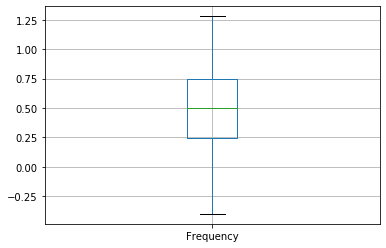

In [8]:
boxplot = df_ds.boxplot(column=['Frequency'])

In [9]:
df_ds['Frequency'].describe()

count    37492.000000
mean         0.499084
std          0.304914
min         -0.401442
25%          0.244851
50%          0.499795
75%          0.747585
max          1.281203
Name: Frequency, dtype: float64

'Frequency' indicates how frequently the transactions are being made. The higher the number is, the more frequently the customer uses the credit card. But we can see some frequencies are below 0 so we need to pull out their percentage.

In [10]:
# Calculate the percentage where 'Frequency' is below 0
(df_ds['Frequency'] < 0).sum()/ len(df_ds) *100

3.9635122159394007

In [11]:
(df_ds['Frequency'] < 0).sum() 

1486

In [12]:
# Calculate the percentage where 'Frequency' is below 0.75 and above 0.25
((df_ds['Frequency'] < 0.75) & (df_ds['Frequency'] > 0.25)).sum() /  len(df_ds) *100

49.75194708204417

In [13]:
((df_ds['Frequency'] < 0.75) & (df_ds['Frequency'] > 0.25)).sum() 

18653

In [14]:
# Calculate the percentage where 'Frequency' is above 1
(df_ds['Frequency'] > 1).sum() / len(df_ds) *100

3.9821828656780114

In [15]:
(df_ds['Frequency'] > 1).sum() 

1493

- As we can see, 18,947 customers are the 50% of the whole population have around 0.5 'Frequency' during the first week after receiving the new credit card.

- 1,475 customers have extremely high 'Frequency' whom are ranked in the top 3.89% level. 

- 3.89% of 'Frequency' are negative, 1,476 customers did not even make a purchase. Possible reasons may include:

    - They applied more than one credit card at the same time and were attracted by other cards.
    - They got approvd the credit card but did not like the service, promotion or other factors, so they have not  decided to whether activate it or not.
    - They may not get a chance to activate the card in the first week.

It is important to understand why 3.89% of customers apperared to be 'infrequent' at an early stage. Bank can try to collect their feedback, for example, take the initiative to call them and help them activate their cards in the first place. At least, bank can run a phone survey to understand their concerns and try to address their problems before they churn.

Let's see the distribution of 'TransactionAmt'.

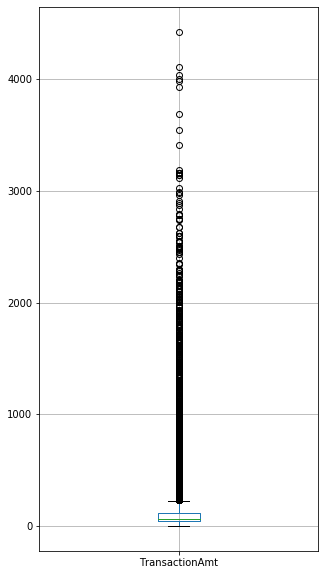

In [16]:
boxplot = df_ds.boxplot(column=['TransactionAmt'],figsize=(5,10))

In [17]:
df_ds['TransactionAmt'].describe()

count    37492.000000
mean       132.385413
std        222.321623
min          0.272000
25%         41.950000
50%         67.950000
75%        117.000000
max       4425.970000
Name: TransactionAmt, dtype: float64

In [18]:
# Calculate the percentage of 'TransactionAmt' above 117 dollars
(df_ds['TransactionAmt'] > 117).sum() / len(df_ds) *100

24.69060066147445

In [19]:
(df_ds['TransactionAmt'] > 117).sum()

9257

In [20]:
len(df_ds)

37492

Clearly, there are lots of outliers above Quartile 3 that means 75% of customers their tansaction amount during the first week was less than 117 dollars, while the dollar amount spend by top 25% of customers was more than 117 dollars and up to maximum 5047.47 dollars.

These outliers are about 1/4 of the whole customers. Due to the significant difference in credit card consumption habits, this boxplot is extremely skewed and not very informative. To learn about the underlying patterns of credit card usage, we will focus on the behaviors of the majority of the customers.

### Comparing 'IsRetention'

In the plot above we can see that some customers received the credit card but then never activate it, some customers just made a low usage in their first week, and some spent a lot! What we want is for customers to develop a habbit and convert this card to their top of wallet option.

Retention rate is the percentage of customers that come back and use the card after they have activated it, which is an important metric in measuring new customers. The higher the retention rate is, the easier it is to retain customers and build a large customer base.

In [21]:
df_ds['isRetention'].mean()

0.4687666702229809

A little less than half of the customers started to use the card one week after receiving it. Now that we have a benchmark, let's look at how one week retention differs between the two AB-groups.

In [22]:
df_ds.groupby('CardType')['isRetention'].mean() *100

CardType
gold        47.636829
platinum    46.116505
Name: isRetention, dtype: float64

It appears that there was a slight decrease in one week retention when the card type is platinum (45.83%) compared to the control which gold group(47.78%). It's a small change, but even small changes in retention can have a large impact. But while we are certain of the difference in the data, how certain should we be that platinum group will be worse in the future?

There are a couple of ways we can get at the certainty of these retention numbers. Here we will use bootstrapping: We will repeatedly re-sample our dataset (with replacement) and calculate one week retention for those samples. The variation in one week retention will give us an indication of how uncertain the retention numbers are.

Text(0.5, 1.0, '% means comparsion of Retention Rate in two groups')

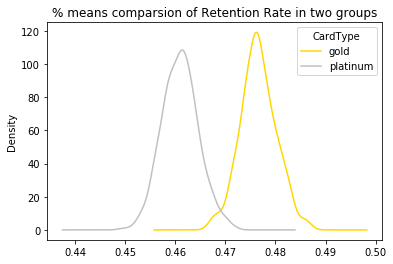

In [24]:
# Creating an list with bootstrapped means for each AB-group
boot_1w = []
for i in range(1000):
    boot_mean = df_ds.sample(frac = 1,replace = True).groupby('CardType')['isRetention'].mean()
    boot_1w.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_1w = pd.DataFrame(boot_1w)

    
# A Kernel Density Estimate plot of the bootstrap distributions
ax = boot_1w.plot(kind='density', color=['gold', 'silver'])
ax.set_title('% means comparsion of Retention Rate in two groups')


These two distributions above represent the bootstrap uncertainty over what the underlying one week retention could be for the two AB-groups. There seems to be some evidence of a difference. Let's plot the % difference to have a closer look.

Probability that one week retention is greater of gold group: 0.998


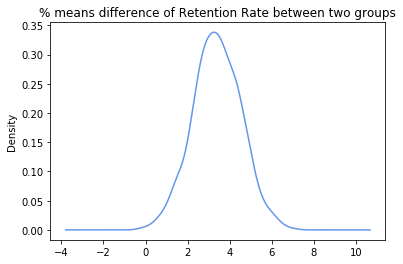

In [25]:
# Adding a column with the % difference between the two AB-groups
boot_1w['diff'] = (boot_1w.gold - boot_1w.platinum)/boot_1w.platinum*100

# Ploting the bootstrap % difference
ax = boot_1w['diff'].plot(kind='density', color='cornflowerblue')
ax.set_title('% means difference of Retention Rate between two groups')

# Calculating the probability that one week retention is greater of gold group
print('Probability that one week retention is greater of gold group:',(boot_1w['diff'] > 0).mean())

From this chart, we can see that the most likely % difference is around 4%, and that 92% of the distribution is above 0%, in favor of gold group.

### Conclusion 

The bootstrap result tells us that there is strong evidence that one week retention is higher when people have gold card than others have platinum card. The conclusion is: If we want to keep retention high — we should upsell gold card to customers than only letting them keep existing platinum card.

There are, of course, other metrics we could look at, like the frequency or how much transaction amount are made by the two AB-groups. But retention is one of the most important metrics. If we don't retain our customer base, it doesn't matter how much money they spend using this credit card.
